In [1]:
from datetime import datetime, timezone, timedelta
import pandas as pd
from io import StringIO
import import_ipynb
from evaluation import to_timestamp, request_influxdb, query_data, histplots, boxplots, lineplots, missing_data, correlation


importing Jupyter notebook from evaluation.ipynb


In [2]:
# Load Tangaras
tangaras = pd.read_csv('../data/tangaras.csv')
tangaras.shape

(22, 7)

In [3]:
# Start Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
start_timestamp = to_timestamp('2023-03-17T00:00:00-05:00')
#start_timestamp = to_timestamp('2023-04-03T00:00:00-05:00')
# End Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
end_timestamp = to_timestamp('2023-03-31T00:00:00-05:00')
#end_timestamp = to_timestamp('2023-04-04T00:00:00-05:00')

print(f'Since: {start_timestamp} Until: {end_timestamp}')


Since: 1679029200000 Until: 1680238800000


In [4]:
# Query Data Sensors
query = query_data(tangaras, start_timestamp, end_timestamp, datatype='hum')
print(query)

SELECT "name", last("hum") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE0DD66') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("hum") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE0E752') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("hum") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE1260A') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("hum") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE94B1A') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("hum") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE965F2') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("hum") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DEBD89A') AND time >= 1679029200000ms AND time <= 168

In [5]:
# Get Data Frame Sensors
def df_sensors(tangaras, start_timestamp, end_timestamp):
    # Data Frame Sensors
    df_sensors = []
    # SQL Query Data Sensors
    query = query_data(tangaras, start_timestamp, end_timestamp, datatype='hum')
    # InfluxDB API REST Request
    influxdb_request = request_influxdb(query)
    #print(influxdb_request)
    #print(influxdb_request.text)

    # Data Frame InfluxDB Sensors
    df_influxdb_sensors = pd.read_csv(StringIO(influxdb_request.text), sep=",", low_memory=False)

    # Remove/Add Columns
    df_influxdb_sensors = df_influxdb_sensors[['time', 'name.1', 'last']]
    df_influxdb_sensors.rename(columns={'time': 'DATETIME', 'name.1': 'MAC', 'last': 'HUM'}, inplace=True)

    # Truncate Response
    for index, row in tangaras.iterrows():
        df_sensor = df_influxdb_sensors.loc[df_influxdb_sensors['MAC'] == row['MAC']].reset_index(drop=True)[['DATETIME', 'HUM']] # Warning
        if not df_sensor.empty:
            df_sensor.rename(columns={'HUM': row['ID']}, inplace=True)
            df_sensor.set_index('DATETIME', inplace=True)
            df_sensors.append(df_sensor)
    
    df_sensors = df_sensors[0].join(df_sensors[1:]).reset_index()

    # Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
    tz = timezone(timedelta(hours=-5))
    df_sensors['DATETIME'] = df_sensors['DATETIME'].apply(lambda x: datetime.fromtimestamp(int(x) / 1000, tz=tz).isoformat())

    df_sensors[df_sensors.columns.to_list()[1:]] = df_sensors[df_sensors.columns.to_list()[1:]].astype('float64')
    
    return df_sensors


In [6]:
# Data Frame Sensors
hum_raw = df_sensors(tangaras, start_timestamp, end_timestamp)
hum_raw.head()

,DATETIME,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
0,2023-03-17T18:49:30-05:00,0.0,82.48,NaN,83.35,NaN,86.08,83.34,NaN,NaN,...,50.93,59.64,55.65,61.37,NaN,79.25,86.80,91.5,48.09,NaN
1,2023-03-17T18:50:00-05:00,0.0,81.85,NaN,83.03,NaN,86.02,83.48,NaN,50.80,...,50.85,59.86,55.70,61.33,NaN,78.86,86.53,91.5,48.11,NaN
2,2023-03-17T18:51:00-05:00,0.0,82.16,NaN,82.98,NaN,85.88,83.29,NaN,50.89,...,50.92,59.70,55.79,60.78,NaN,78.88,86.64,91.6,48.16,NaN
3,2023-03-17T18:51:30-05:00,0.0,82.36,NaN,82.96,NaN,85.70,83.14,NaN,50.95,...,NaN,59.75,55.83,61.24,NaN,78.80,86.47,91.6,48.13,NaN
4,2023-03-17T18:52:00-05:00,0.0,82.07,NaN,82.89,NaN,85.85,83.14,NaN,51.02,...,50.60,59.93,55.80,61.16,NaN,78.69,86.52,91.7,48.16,NaN


# Descriptive Statistics

In [7]:
# Describe Data
hum_raw.describe()

,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,TANGARA_1A1E,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
count,27537.0,27066.000000,7384.000000,26889.000000,8035.000000,26887.000000,26595.000000,1090.000000,26758.000000,25374.000000,...,25781.000000,27407.000000,26121.000000,26177.000000,16471.000000,26939.000000,26773.000000,27272.000000,26978.000000,26368.000000
mean,0.0,70.731546,70.041995,67.415317,70.747442,74.254824,66.523695,52.428156,56.628130,60.115693,...,61.300344,64.213928,56.899268,66.956639,62.528925,64.185329,74.594819,94.890323,56.829068,61.428478
std,0.0,7.581711,6.273192,8.790291,5.881006,8.220065,9.482045,5.758537,6.494922,14.175215,...,14.020078,7.645527,5.803146,11.547096,16.354384,8.868734,8.705258,7.112086,9.214970,10.414639
min,0.0,45.930000,52.240000,40.550000,52.870000,47.670000,39.260000,39.760000,41.700000,31.800000,...,36.340000,39.370000,40.630000,42.860000,31.190000,35.950000,45.580000,70.900000,38.530000,40.130000
25%,0.0,66.520000,66.757500,61.980000,68.210000,69.820000,60.540000,47.075000,50.730000,46.940000,...,47.660000,58.565000,53.870000,56.070000,46.780000,58.970000,69.970000,91.400000,48.390000,52.190000
50%,0.0,74.060000,71.880000,71.110000,72.540000,77.450000,66.820000,53.220000,56.970000,62.225000,...,62.600000,64.770000,57.750000,69.550000,65.480000,67.930000,78.690000,99.900000,56.970000,62.750000
75%,0.0,76.050000,73.660000,74.090000,74.990000,80.100000,75.380000,57.570000,62.420000,73.017500,...,73.910000,70.440000,61.300000,77.710000,77.980000,70.660000,80.560000,99.900000,64.887500,70.740000
max,0.0,82.480000,90.150000,83.350000,91.430000,89.100000,83.480000,65.190000,67.830000,89.190000,...,96.670000,81.330000,71.530000,84.700000,89.500000,79.250000,86.800000,99.900000,90.490000,81.970000


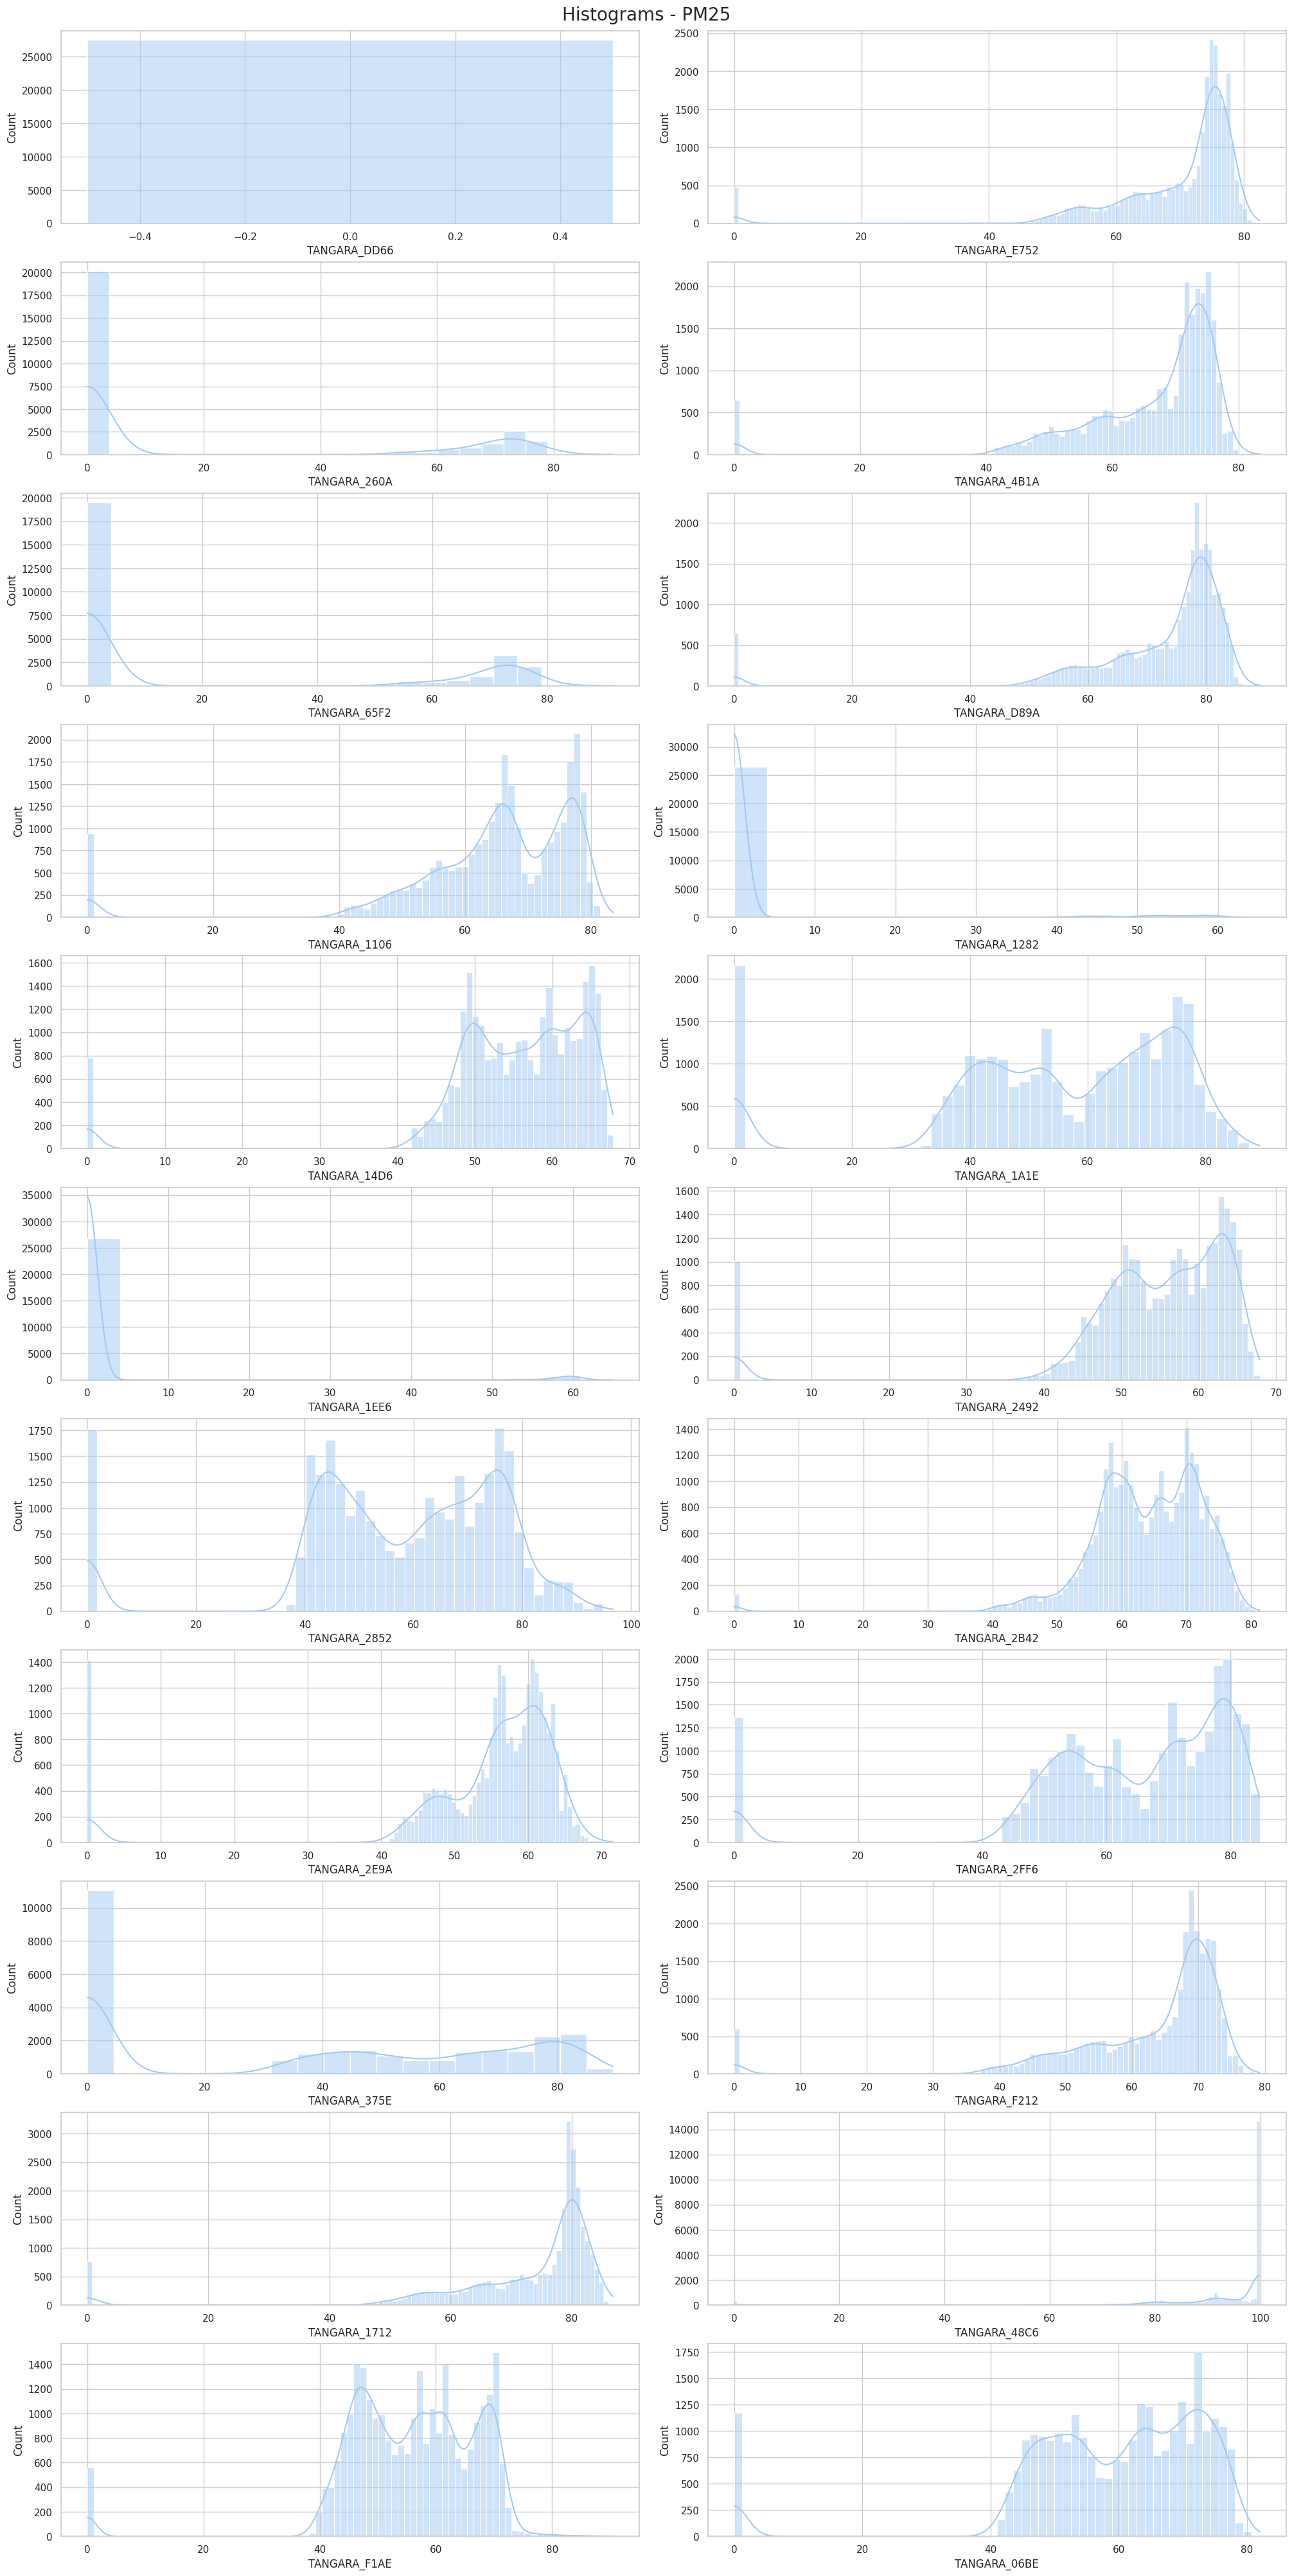

In [8]:
# Plot Humidity Histograms
histplots(hum_raw)

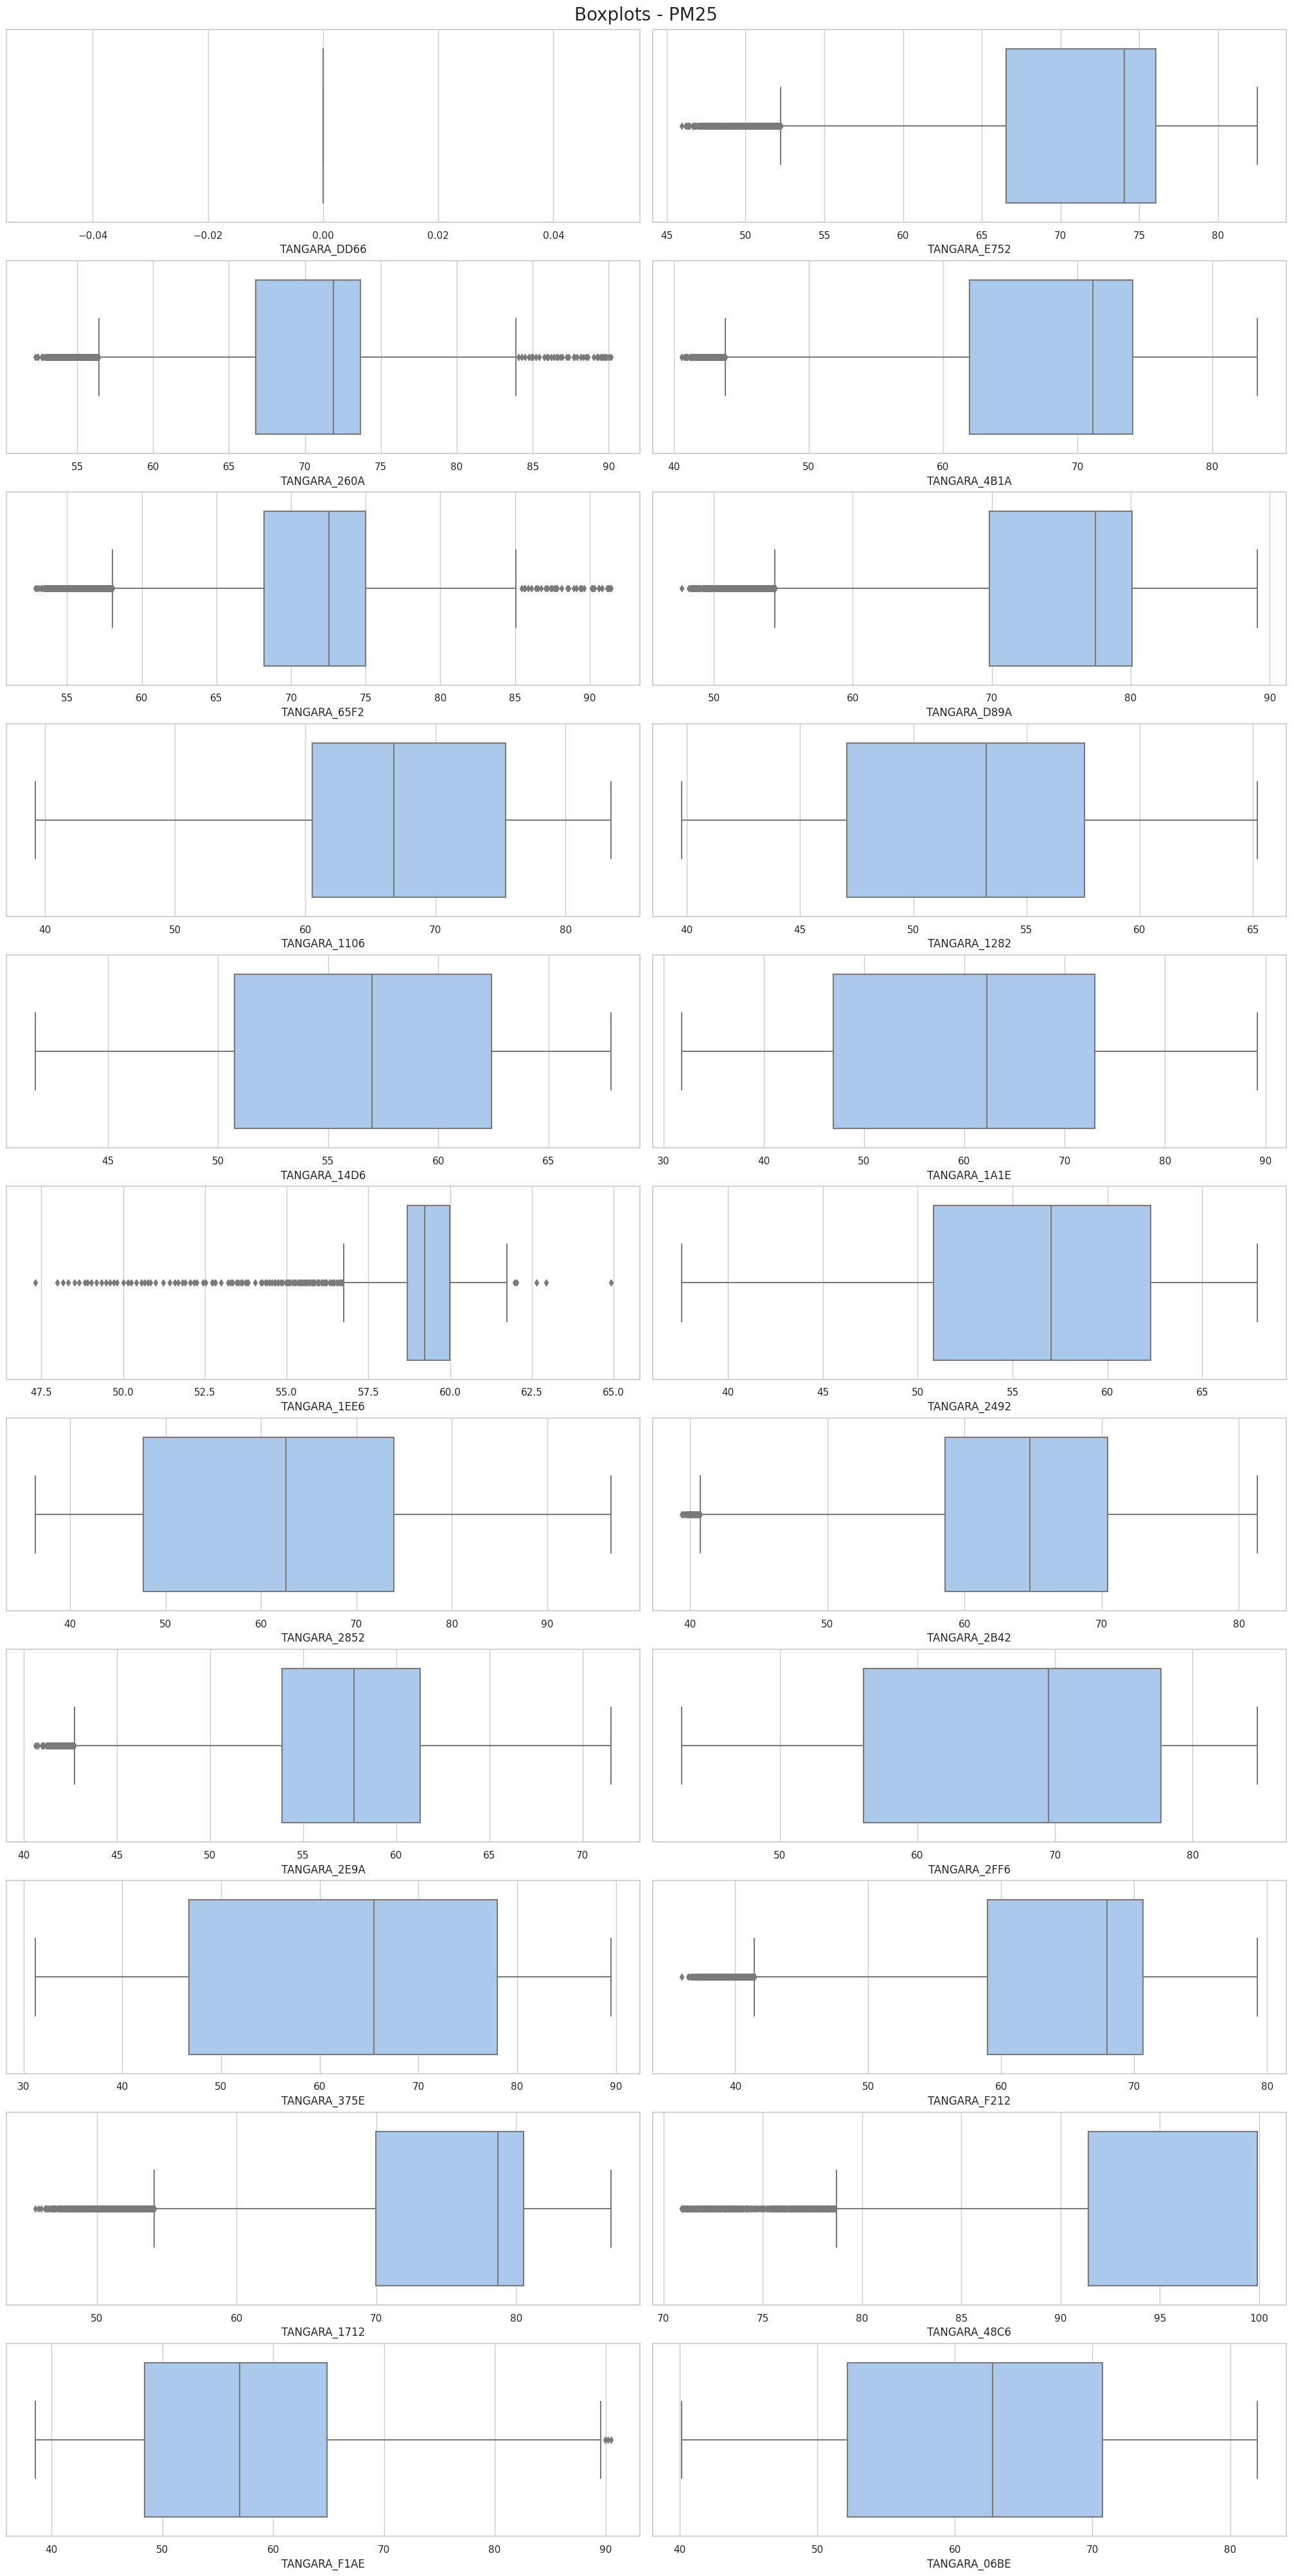

In [9]:
# Plot Humidity Boxplots
boxplots(hum_raw)

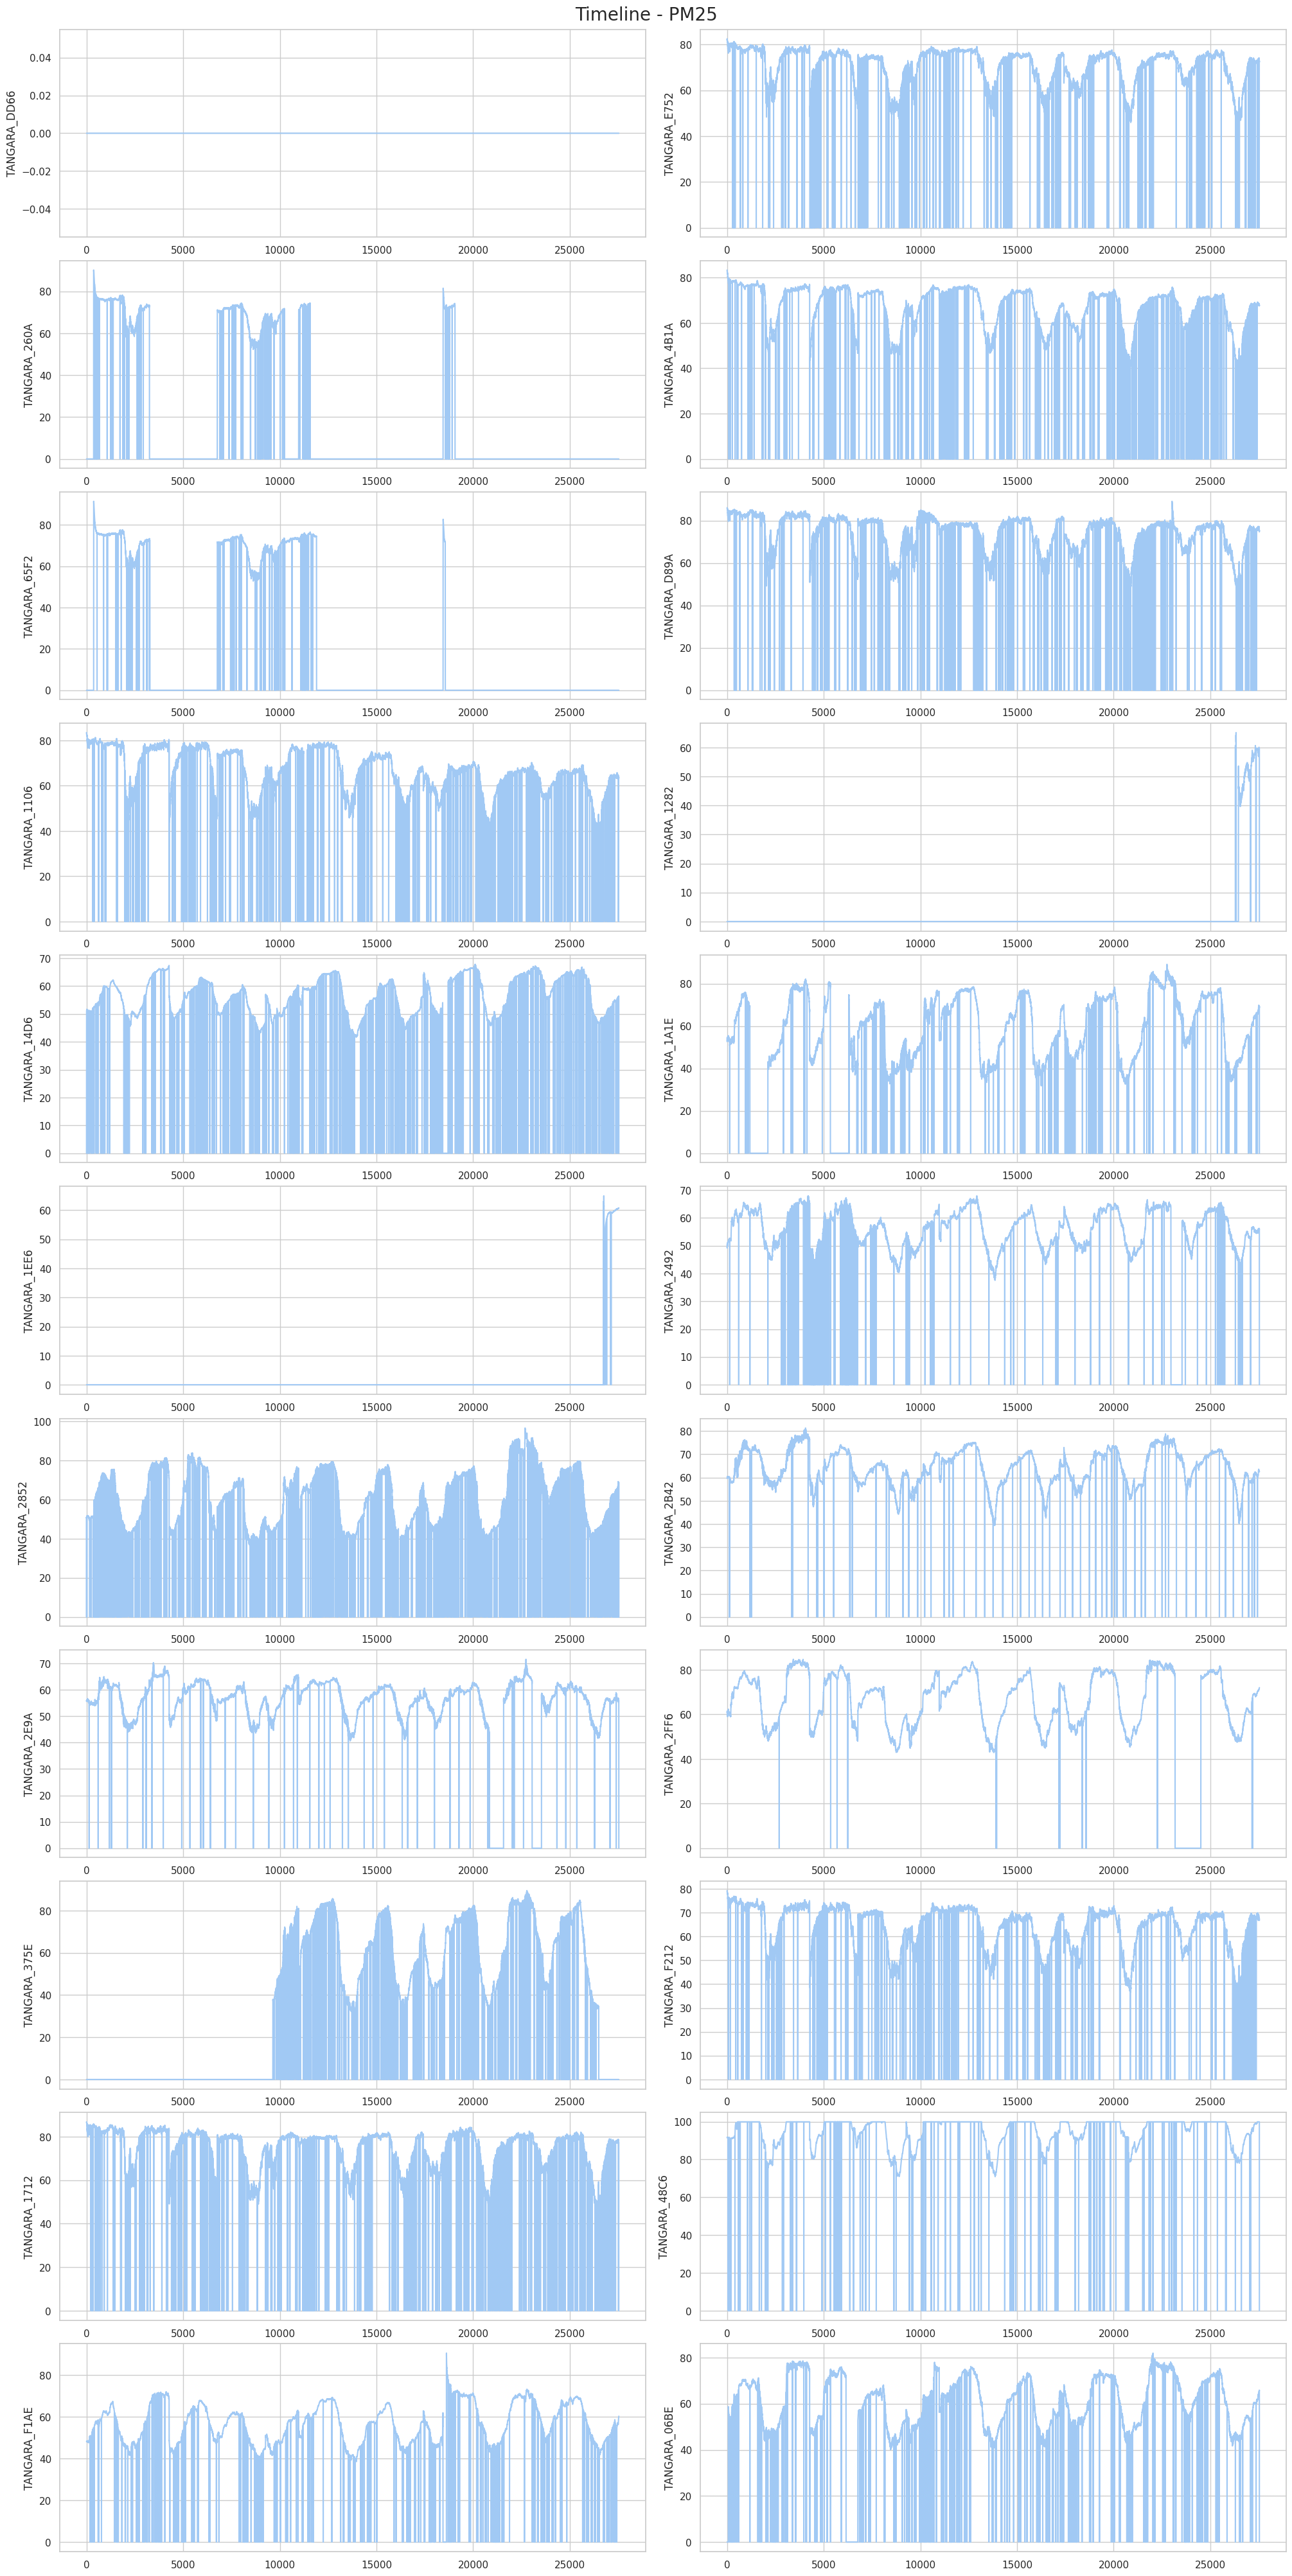

In [10]:
# Plot Humidity Lineplots
lineplots(hum_raw)

In [11]:
# Missing Data Sensors
threshold = 85
to_be_checked = missing_data(hum_raw, threshold)

print(f'Threshold: {threshold}%')
print(f'Total Sensors: {len(hum_raw.columns[1:])}')
print(f'To Be Checked: {len(to_be_checked)}')
to_be_checked

Threshold: 85%
Total Sensors: 22
To Be Checked: 5


[{'ID': 'TANGARA_260A', 'Data': '27%', 'Missing': '73%'},
 {'ID': 'TANGARA_65F2', 'Data': '29%', 'Missing': '71%'},
 {'ID': 'TANGARA_1282', 'Data': '4%', 'Missing': '96%'},
 {'ID': 'TANGARA_1EE6', 'Data': '3%', 'Missing': '97%'},
 {'ID': 'TANGARA_375E', 'Data': '60%', 'Missing': '40%'}]

In [12]:
# Sensors to evaluate by Pearson correlation coefficient
sensors_to_evaluate = hum_raw[['DATETIME', 'TANGARA_DD66', 'TANGARA_E752', 'TANGARA_4B1A', 'TANGARA_D89A', 'TANGARA_1106', 'TANGARA_F212', 'TANGARA_1712']]

# Pearson correlation coefficient
threshold = 0.7
to_be_checked = correlation(sensors_to_evaluate, 'TANGARA_D89A', threshold)

# Correlation Sensors
print(f'Threshold: {threshold}')
print(f'Total Sensors: {len(sensors_to_evaluate.columns[1:])}')
print(f'To Be Checked: {len(to_be_checked)}')
to_be_checked


Threshold: 0.7
Total Sensors: 7
To Be Checked: 1


[{'Reference': {'ID': 'TANGARA_D89A', 'Data': 38061, 'Freq': <30 * Seconds>},
  'Target': {'ID': 'TANGARA_DD66', 'Data': 38061, 'Freq': <30 * Seconds>},
  'Correlation': 0}]

In [13]:
# Save Humidity raw data into CSV file
hum_raw.to_csv('../data/hum_raw.csv', index=False)